Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error

#outlier detection.
from scipy.stats import zscore

# Statistical / Time Series Models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\indra\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Data Collection and  Exploration

In [2]:
df = pd.read_csv("data/train.csv", parse_dates=["date"])
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


| Column        | Description                                        |
| ------------- | -------------------------------------------------- |
| `id`          | Unique identifier for each record                  |
| `date`        | Date of the sales record                           |
| `store_nbr`   | Store number (1, 2, …, n)                          |
| `family`      | Product family/category (e.g., BEVERAGES, PRODUCE) |
| `sales`       | Number of items sold (target variable)             |
| `onpromotion` | Number of items on promotion (0 = no, 1 = yes)     |

In [3]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion
1048570,1048570,2014-08-13,3,POULTRY,974.098,1
1048571,1048571,2014-08-13,3,PREPARED FOODS,324.293,0
1048572,1048572,2014-08-13,3,PRODUCE,10.000,1
1048573,1048573,2014-08-13,3,SCHOOL AND OFFICE SUPPLIES,0.000,0
1048574,1048574,2014-08-13,3,SEAFOOD,69.116,0


In [4]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='str')

In [5]:
df.shape

(1048575, 6)

In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1048575 non-null  int64         
 1   date         1048575 non-null  datetime64[us]
 2   store_nbr    1048575 non-null  int64         
 3   family       1048575 non-null  str           
 4   sales        1048575 non-null  float64       
 5   onpromotion  1048575 non-null  int64         
dtypes: datetime64[us](1), float64(1), int64(3), str(1)
memory usage: 48.0 MB


In [7]:
df.describe()

,id,date,store_nbr,sales,onpromotion
count,1.048575e+06,1048575,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.242870e+05,2013-10-22 02:30:51.946499,2.749256e+01,2.445326e+02,1.147634e-01
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.621435e+05,2013-05-28 00:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,5.242870e+05,2013-10-22 00:00:00,2.700000e+01,1.000000e+00,0.000000e+00
75%,7.864305e+05,2014-03-19 00:00:00,4.100000e+01,1.200000e+02,0.000000e+00
max,1.048574e+06,2014-08-13 00:00:00,5.400000e+01,4.627100e+04,1.960000e+02
std,3.026977e+05,NaN,1.558408e+01,8.065892e+02,2.377814e+00


In [8]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Then set it as index
df.set_index('date', inplace=True)

# Check
df.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [9]:
# Drop unnecessary columns
df = df.drop(['id'], axis=1)

In [10]:
df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


In [11]:
# 2. Check missing values
print(df.isnull().sum())

store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [12]:
# 4. Sort values by store, family, date
df.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

In [13]:
df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-02,1,AUTOMOTIVE,2.0,0
2013-01-03,1,AUTOMOTIVE,3.0,0
2013-01-04,1,AUTOMOTIVE,3.0,0
2013-01-05,1,AUTOMOTIVE,5.0,0


In [14]:
# Create a combined store-family identifier
df['store_family'] = df['store_nbr'].astype(str) + '_' + df['family']
df.head()

,store_nbr,family,sales,onpromotion,store_family
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,1_AUTOMOTIVE
2013-01-02,1,AUTOMOTIVE,2.0,0,1_AUTOMOTIVE
2013-01-03,1,AUTOMOTIVE,3.0,0,1_AUTOMOTIVE
2013-01-04,1,AUTOMOTIVE,3.0,0,1_AUTOMOTIVE
2013-01-05,1,AUTOMOTIVE,5.0,0,1_AUTOMOTIVE


In [15]:
df = df.drop(['store_nbr', 'family'], axis=1)
df.head()

,sales,onpromotion,store_family
date,,,
2013-01-01,0.0,0,1_AUTOMOTIVE
2013-01-02,2.0,0,1_AUTOMOTIVE
2013-01-03,3.0,0,1_AUTOMOTIVE
2013-01-04,3.0,0,1_AUTOMOTIVE
2013-01-05,5.0,0,1_AUTOMOTIVE


In [16]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2014-08-03', '2014-08-04', '2014-08-05', '2014-08-06',
               '2014-08-07', '2014-08-08', '2014-08-09', '2014-08-10',
               '2014-08-11', '2014-08-12'],
              dtype='datetime64[us]', name='date', length=1048575, freq=None)

In [17]:
df.duplicated().sum()

np.int64(764119)

In [18]:
df = df.drop_duplicates()

In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
# Aggregate daily sales
daily_sales = df.pivot_table(
    index='date', 
    columns='store_family', 
    values='sales', 
    aggfunc='sum'
)

In [21]:
# Total daily sales across all stores and families
daily_sales['total_sales'] = daily_sales.sum(axis=1)
daily_sales['total_sales'] .head()


date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361211.231124
2013-01-04    354195.677093
2013-01-05    473226.121229
Name: total_sales, dtype: float64

In [22]:
# 30-day rolling average to show trend
daily_sales['rolling_mean'] = daily_sales['total_sales'].rolling(30).mean()
daily_sales['rolling_mean']

date
2013-01-01              NaN
2013-01-02              NaN
2013-01-03              NaN
2013-01-04              NaN
2013-01-05              NaN
                  ...      
2014-08-09    524452.556332
2014-08-10    523780.756672
2014-08-11    511832.667996
2014-08-12    498744.298101
2014-08-13    483746.443930
Name: rolling_mean, Length: 589, dtype: float64

In [23]:
# Identify top 5 product families by total sales
family_sales = df.groupby('store_family')['sales'].sum().sort_values(ascending=False)
family_sales

store_family
44_GROCERY I         4887731.0
45_GROCERY I         4628624.0
47_GROCERY I         4383763.0
46_GROCERY I         4050516.0
48_GROCERY I         3696867.0
                       ...    
22_POULTRY                 0.0
12_BABY CARE               0.0
12_BOOKS                   0.0
22_PREPARED FOODS          0.0
11_BOOKS                   0.0
Name: sales, Length: 1782, dtype: float64

In [24]:
top5_families = family_sales.head(5).index.tolist()
top5_families

['44_GROCERY I',
 '45_GROCERY I',
 '47_GROCERY I',
 '46_GROCERY I',
 '48_GROCERY I']

In [25]:
# Pivot only top 5 families
top5_daily = df[df['store_family'].isin(top5_families)].pivot_table(
    index='date', columns='store_family', values='sales', aggfunc='sum')

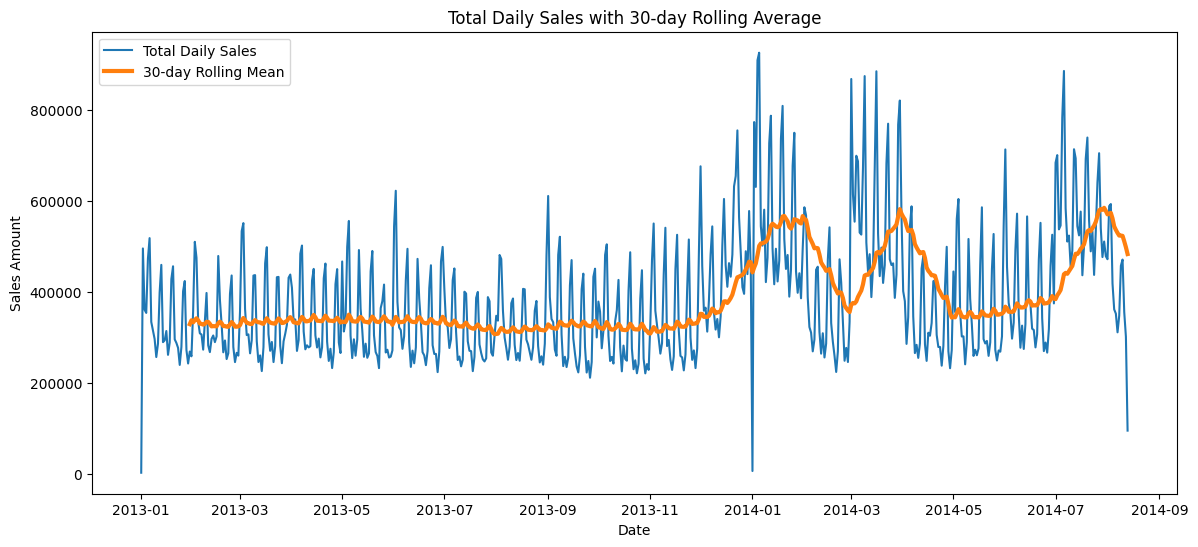

In [26]:
# Plot total daily sales with rolling trend
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(daily_sales.index, daily_sales['total_sales'], label='Total Daily Sales')
plt.plot(daily_sales.index, daily_sales['rolling_mean'], label='30-day Rolling Mean', linewidth=3)
plt.title("Total Daily Sales with 30-day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()

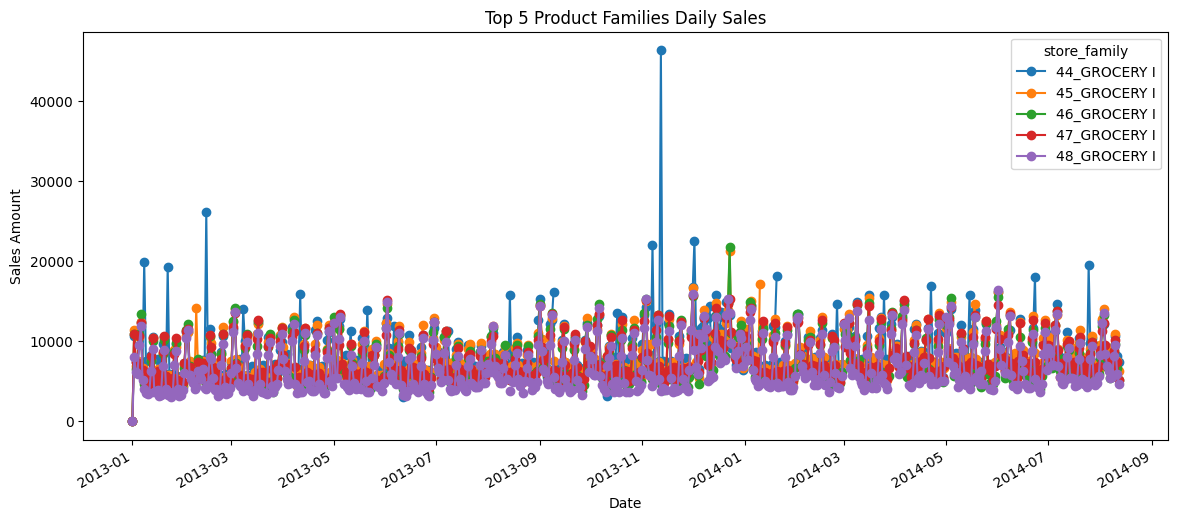

In [27]:
# Plot top 5 product families
top5_daily.plot(figsize=(14,6), marker='o', title='Top 5 Product Families Daily Sales')
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.show()

Data Cleaning and Transformation

In [28]:
# Aggregate daily sales

# Sum sales across all stores and product families
daily_sales = df.resample('D')['sales'].sum()



# Handle missing dates

# Ensure continuous daily frequency
daily_sales = daily_sales.asfreq('D')
daily_sales = daily_sales.interpolate()

In [29]:
# Outlier detection (analysis only)
from scipy.stats import zscore
z_scores = zscore(daily_sales)
outliers = np.abs(z_scores) > 3
print(f"Number of detected outliers: {outliers.sum()}")

Number of detected outliers: 8


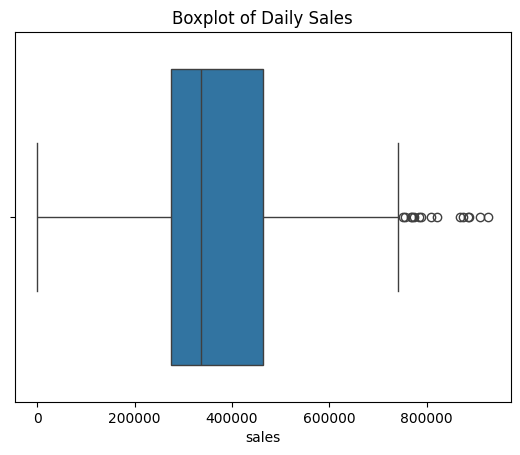

In [30]:
#Outlier Visualization
sns.boxplot(x=daily_sales)
plt.title("Boxplot of Daily Sales")
plt.show()

NOTE:
- Outliers are not removed because sales spikes represent
- real-world events like promotions and holidays

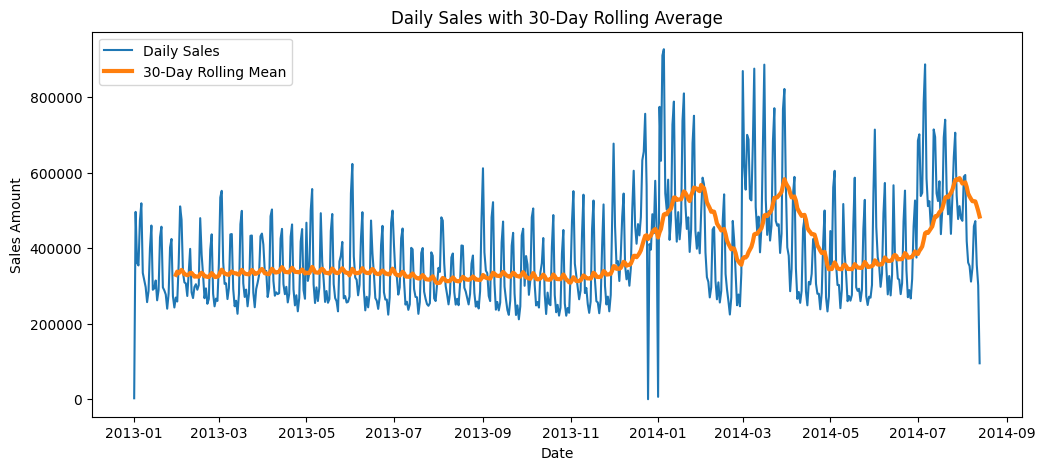

                    sales  day_of_week  month  year  week_of_year
date                                                             
2013-01-01    2511.618999            1      1  2013             1
2013-01-02  496092.417944            2      1  2013             1
2013-01-03  361211.231124            3      1  2013             1
2013-01-04  354195.677093            4      1  2013             1
2013-01-05  473226.121229            5      1  2013             1


In [31]:
# Feature Engineering

df_features = daily_sales.to_frame(name='sales')

df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month
df_features['year'] = df_features.index.year
df_features['week_of_year'] = df_features.index.isocalendar().week


# Trend Visualization
plt.figure(figsize=(12,5))
plt.plot(df_features.index, df_features['sales'], label='Daily Sales')
plt.plot(
    df_features.index,
    df_features['sales'].rolling(30).mean(),
    label='30-Day Rolling Mean',
    linewidth=3
)
plt.title("Daily Sales with 30-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()

# Final Clean Dataset
print(df_features.head())

| Step                | Description                                            |
| ------------------- | ------------------------------------------------------ |
| Data Aggregation    | Converts raw store-level data into daily sales         |
| Missing Timestamps  | Ensures continuous daily time series                   |
| Outlier Detection   | Identifies abnormal spikes without deleting real sales |
| Feature Engineering | Extracts seasonality & trend indicators                |
| Resampling          | Regularizes time series frequency                      |
| Visualization       | Smooths trend using rolling mean                       |


Exploratory Data Analysis (EDA)

Trend & Seasonality Visualization

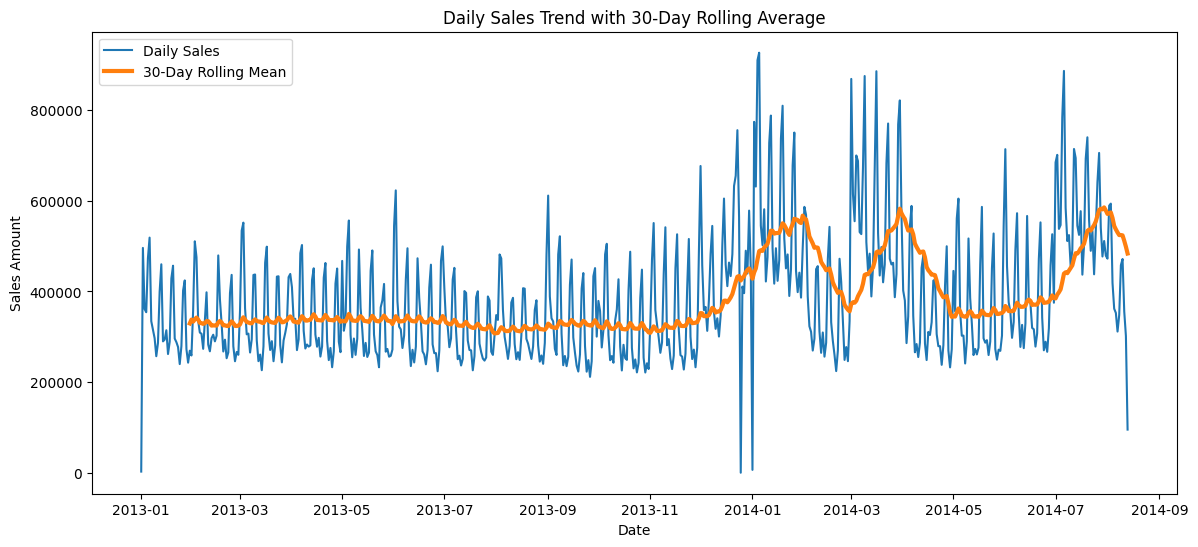

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
plt.plot(daily_sales, label="Daily Sales")
plt.plot(daily_sales.rolling(30).mean(), label="30-Day Rolling Mean", linewidth=3)
plt.title("Daily Sales Trend with 30-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()


Weekly Seasonality

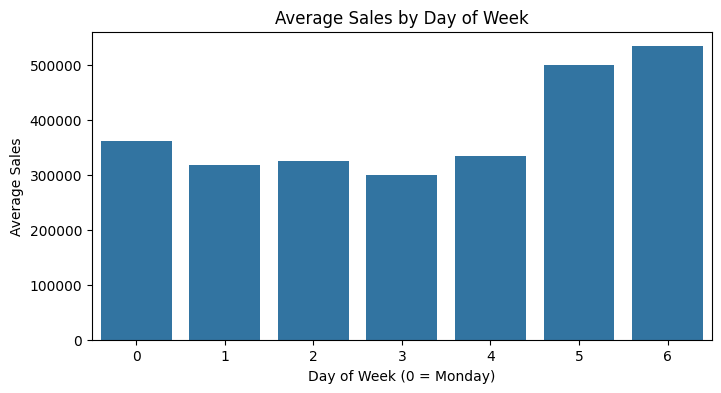

In [33]:
weekly_avg = daily_sales.groupby(daily_sales.index.dayofweek).mean()

plt.figure(figsize=(8,4))
sns.barplot(x=weekly_avg.index, y=weekly_avg.values)
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Average Sales")
plt.show()


Statistical Analysis

Autocorrelation(ACF) & Partial Autocorrelation(PACF)
- Autocorrelation helps identify dependency between current and past values, which is critical for selecting ARIMA/SARIMAX parameters.

<Figure size 1200x400 with 0 Axes>

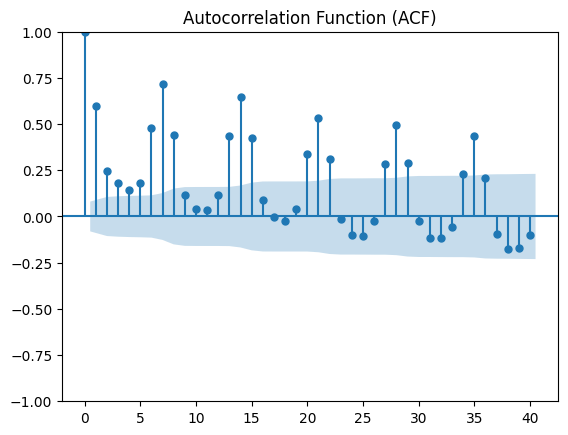

<Figure size 1200x400 with 0 Axes>

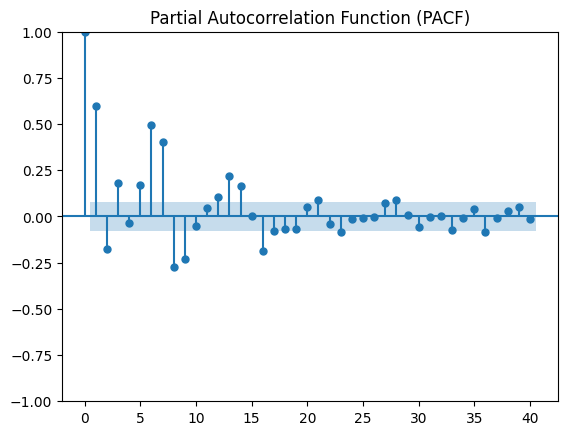

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(daily_sales, lags=40)
plt.title("Autocorrelation Function (ACF)")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(daily_sales, lags=40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


Stationarity Test (ADF Test)
- Stationarity Test (Augmented Dickey-Fuller(ADF Test))

- ADF check Is my time series data stable (stationary) or not?

- p-value ≤ 0.05  →  Data is stationary 

- p-value > 0.05  →  Data is NOT stationary (Differencing required)

In [35]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(daily_sales)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -3.422543779685206
p-value: 0.010213946533724618


Despite the ADF test produced a p-value below 0.05 indicating stationarity, differencing was applied to remove residual trends and enhance model accuracy.

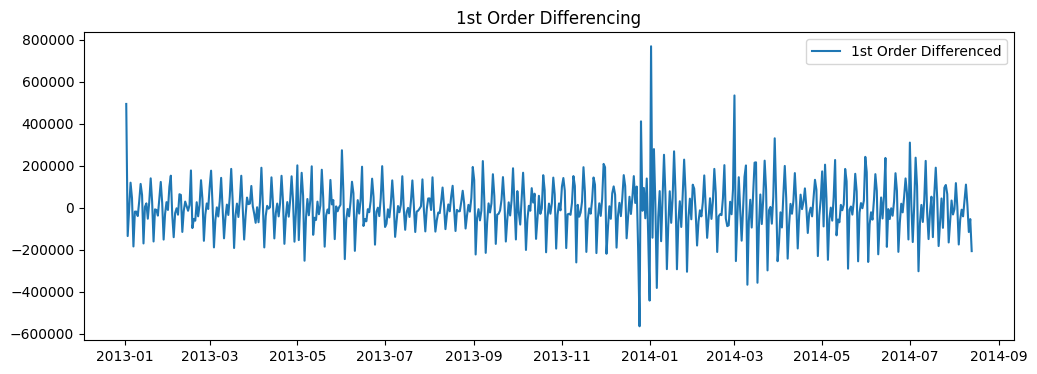

In [36]:
# First-order differencing
diff_1 = daily_sales.diff().dropna()  # subtract previous day
plt.figure(figsize=(12,4))
plt.plot(diff_1, label='1st Order Differenced')
plt.title("1st Order Differencing")
plt.legend()
plt.show()

In [37]:
# Check stationarity after first differencing
adf_result = adfuller(diff_1)
print("ADF Statistic (1st diff):", adf_result[0])
print("p-value (1st diff):", adf_result[1])

ADF Statistic (1st diff): -6.367447319490478
p-value (1st diff): 2.390454342131404e-08


- The p-value is much less than 0.05, which means we reject the null hypothesis of the Augmented Dickey-Fuller (ADF) test.

-  herefore, the first-differenced time series is stationary, meaning it has no significant trend and its statistical properties (mean, variance) are stable over time.

- The first-differenced series is now suitable for time series modeling methods such as ARIMA, SARIMAX, or Prophet.

Model Development

In [38]:
daily = df.resample('D').agg({
    'sales': 'sum',
    'onpromotion': 'sum'
})

daily.head()

,sales,onpromotion
date,,
2013-01-01,2511.618999,0
2013-01-02,496092.417944,0
2013-01-03,361211.231124,0
2013-01-04,354195.677093,0
2013-01-05,473226.121229,0


In [39]:
daily.reset_index().to_csv("data/daily_sales.csv", index=False)
print("daily_sales.csv saved!")

daily_sales.csv saved!


In [40]:
test_days = 30

train = daily.iloc[:-test_days]
test  = daily.iloc[-test_days:]

y_train = train['sales']
y_test  = test['sales']

X_train = train['onpromotion']
X_test  = test['onpromotion']

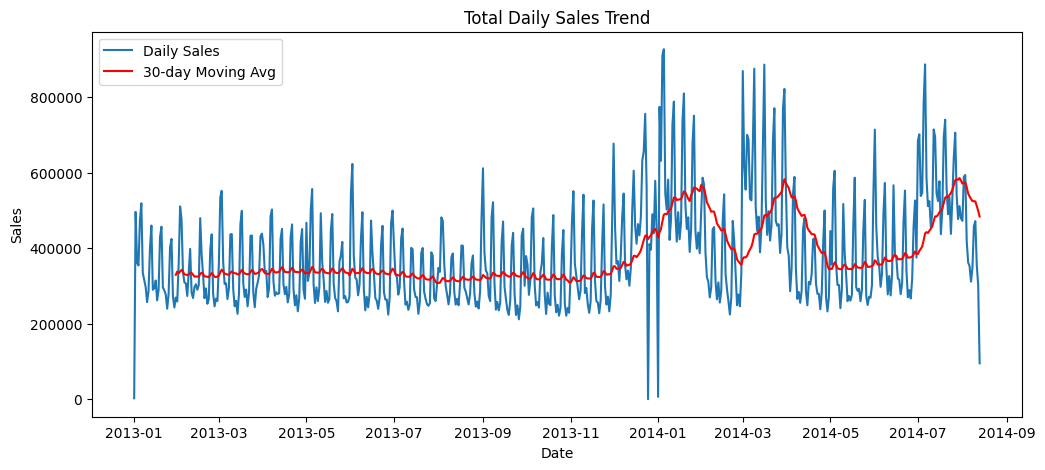

In [41]:
plt.figure(figsize=(12,5))
plt.plot(daily['sales'], label='Daily Sales')
plt.plot(daily['sales'].rolling(30).mean(), label='30-day Moving Avg', color='red')
plt.title("Total Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

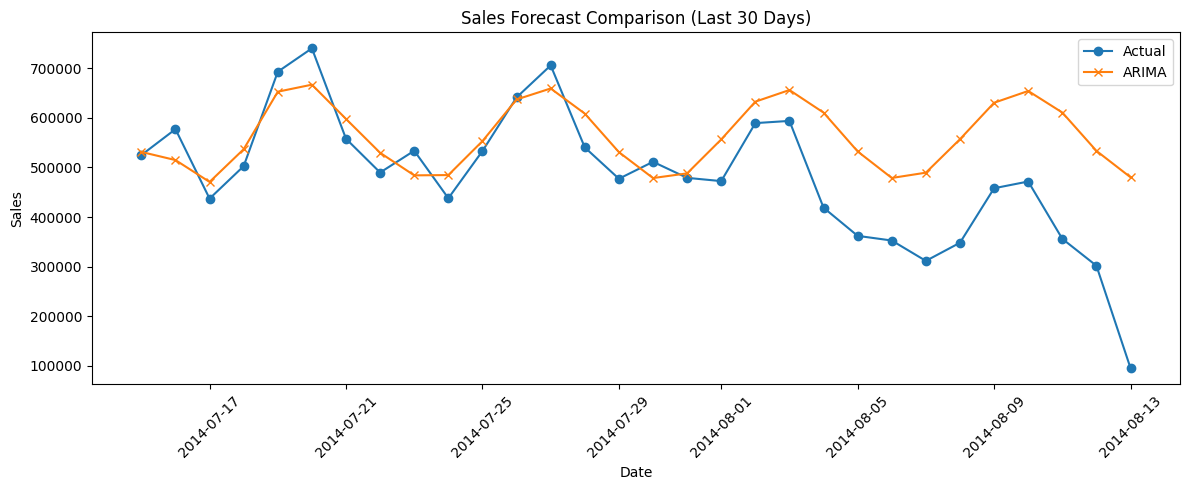

In [42]:
arima_model = ARIMA(y_train, order=(5,1,2))
arima_fit = arima_model.fit()

y_pred_arima = arima_fit.forecast(steps=test_days)

plt.figure(figsize=(12,5))
plt.plot(test.index, y_test, label='Actual', marker='o')
plt.plot(test.index, y_pred_arima, label='ARIMA', marker='x')

plt.title("Sales Forecast Comparison (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

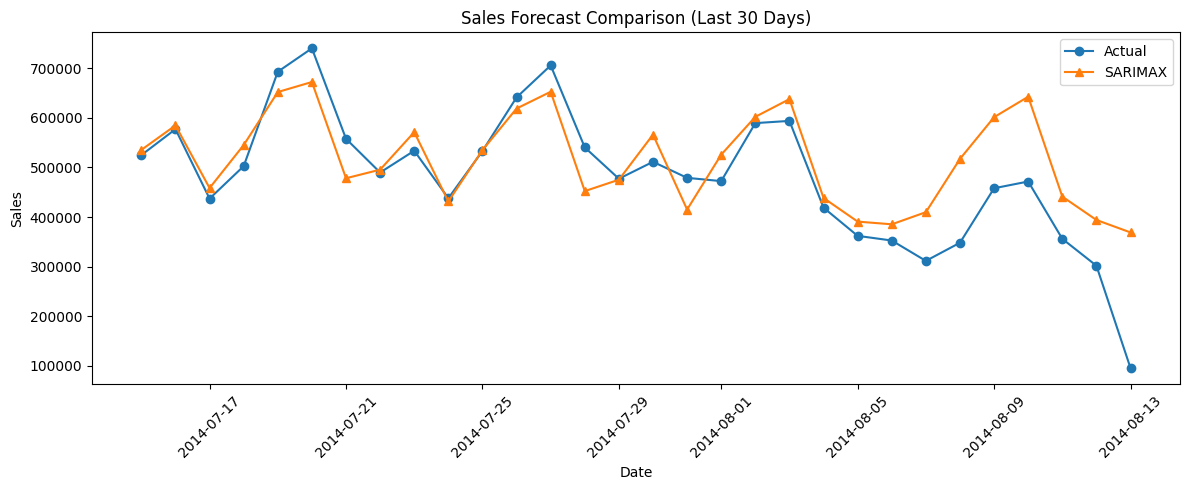

In [43]:
# Ensure exogenous variables are aligned
X_train = X_train.reindex(y_train.index)
X_test  = X_test.reindex(y_test.index)

# Fit SARIMAX model
sarimax_model = SARIMAX(
    y_train,                # training target
    exog=X_train,           # training exogenous variable
    order=(5,1,2),
    seasonal_order=(1,1,1,7)  # weekly seasonality
)
sarimax_result = sarimax_model.fit(disp=False)

# Forecast next 30 days using test promotions
y_pred_sarimax = sarimax_result.forecast(steps=test_days, exog=X_test)

# Plot Actual vs Forecast
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_pred_sarimax, label='SARIMAX', marker='^')
plt.title("Sales Forecast Comparison (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

18:23:21 - cmdstanpy - INFO - Chain [1] start processing
18:23:21 - cmdstanpy - INFO - Chain [1] done processing


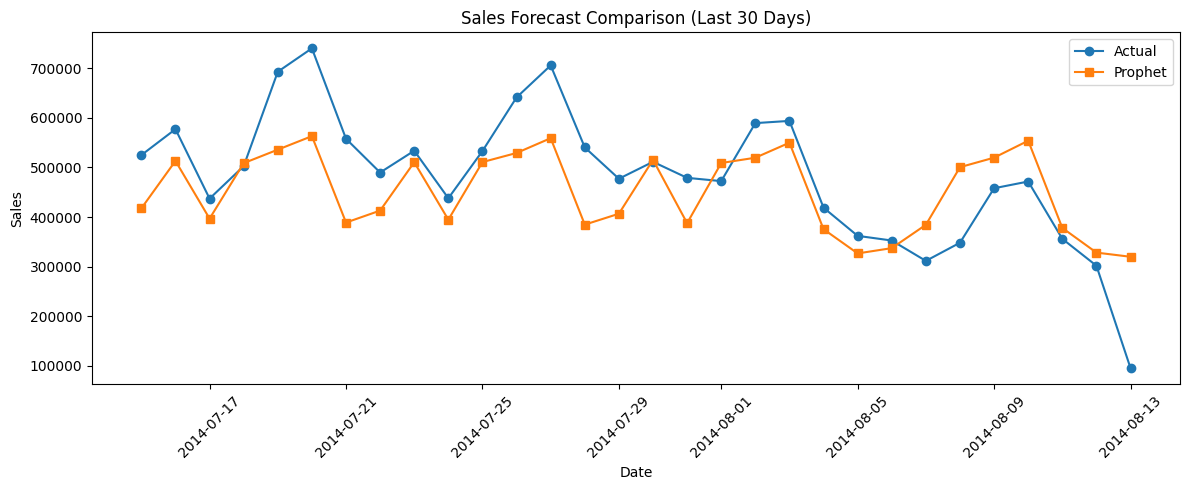

In [44]:
# Prepare Prophet dataframe
prophet_df = daily.reset_index().rename(columns={'date':'ds','sales':'y'})
prophet_df['onpromotion'] = prophet_df['onpromotion'].fillna(0)

# Train/test split
prophet_train = prophet_df.iloc[:-test_days]
prophet_test  = prophet_df.iloc[-test_days:]

y_test = prophet_test['y'].values

# Initialize Prophet
prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=False)
prophet_model.add_regressor('onpromotion')

# Fit model
prophet_model.fit(prophet_train)

# Create future dataframe
future = prophet_model.make_future_dataframe(periods=test_days)
future['onpromotion'] = pd.concat([prophet_train['onpromotion'], prophet_test['onpromotion']], ignore_index=True)

# Forecast
forecast_prophet = prophet_model.predict(future)
y_pred_prophet = forecast_prophet['yhat'].iloc[-test_days:].values

# Plot
plt.figure(figsize=(12,5))
plt.plot(prophet_test['ds'], y_test, label='Actual', marker='o')
plt.plot(prophet_test['ds'], y_pred_prophet, label='Prophet', marker='s')
plt.title("Sales Forecast Comparison (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ARIMA → MAE: 98370.38, RMSE: 133142.43
SARIMAX → MAE: 60998.41, RMSE: 85758.27
Prophet → MAE: 78450.84, RMSE: 97403.17


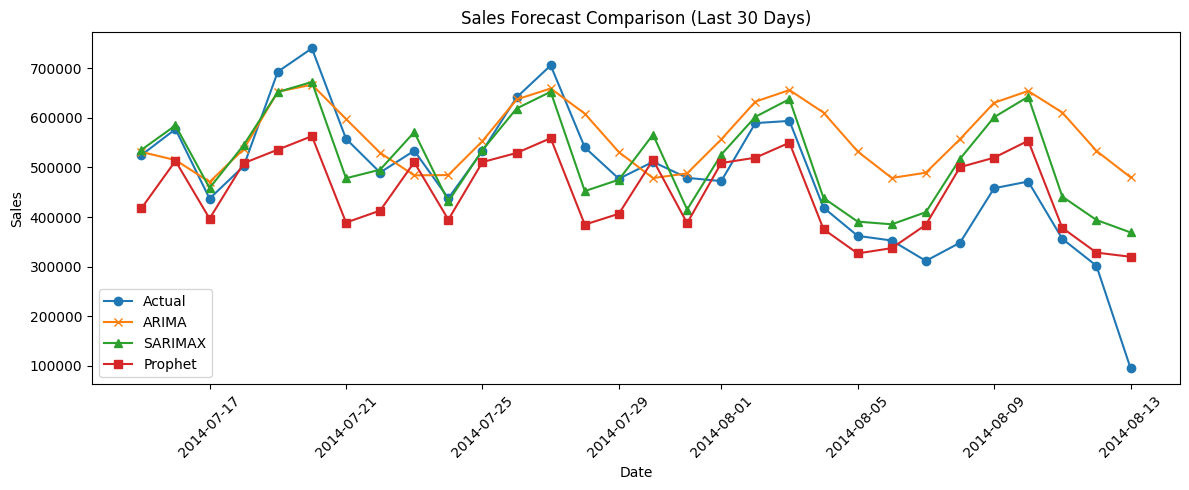

In [45]:
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate(y_test, y_pred_arima, "ARIMA")
evaluate(y_test, y_pred_sarimax, "SARIMAX")
evaluate(y_test, y_pred_prophet, "Prophet")


plt.figure(figsize=(12,5))
plt.plot(test.index, y_test, label='Actual', marker='o')
plt.plot(test.index, y_pred_arima, label='ARIMA', marker='x')
plt.plot(test.index, y_pred_sarimax, label='SARIMAX', marker='^')
plt.plot(test.index, y_pred_prophet, label='Prophet', marker='s')

plt.title("Sales Forecast Comparison (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Conclusion:
- Among ARIMA, SARIMAX, and Prophet models, SARIMAX performed best for daily store sales forecasting, achieving the lowest MAE (60,998.41) and RMSE (85,758.27). By incorporating exogenous variables such as promotions, SARIMAX effectively captured external influences on sales. ARIMA showed the weakest performance due to its inability to model external factors, while Prophet provided reasonable accuracy and good trend visualization but was less precise than SARIMAX. Therefore, SARIMAX is the preferred model for accurate short-term sales forecasting, with Prophet serving as a useful tool for understanding seasonal patterns.

Model Optimization

Parameter Tuning

In [46]:
# ARIMA Grid Search

import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Define ranges for p, d, q
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
pdq = list(itertools.product(p,d,q))

best_aic = float('inf')
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(y_train, order=order)
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = order
            best_model = result
    except:
        continue

print(f"Best ARIMA order: {best_order}, AIC: {best_aic}")

Best ARIMA order: (3, 1, 3), AIC: 14361.443358992015


In [47]:
#SARIMAX Grid Search

from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
seasonal_pdq = [(i,j,k,7) for i in range(0,3) for j in range(0,2) for k in range(0,3)]

best_aic = float('inf')
best_order = None
best_seasonal = None
best_model = None

for order in itertools.product(p,d,q):
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = result
        except:
            continue

print(f"Best SARIMAX order: {best_order}, seasonal_order: {best_seasonal}, AIC: {best_aic}")


Best SARIMAX order: (2, 0, 1), seasonal_order: (1, 1, 1, 7), AIC: 13967.184702532762


In [48]:
# Define grid for parameters
changepoint_scales = [0.01, 0.1, 0.5]  # controls flexibility of trend
seasonality_scales = [0.1, 1.0, 10.0]  # controls seasonality strength
holidays_scales   = [0.1, 1.0, 10.0]   # controls holiday effect

# Prepare train/test
train = prophet_df.iloc[:-test_days]
test  = prophet_df.iloc[-test_days:]
y_test = test['y'].values

best_mae = float('inf')
best_params = None
best_forecast = None

# Grid search
for cp, ss, hs in itertools.product(changepoint_scales, seasonality_scales, holidays_scales):
    model = Prophet(
        weekly_seasonality=True,
        changepoint_prior_scale=cp,
        seasonality_prior_scale=ss,
        holidays_prior_scale=hs,
        daily_seasonality=False
    )
    model.add_regressor('onpromotion')  # if you use promotions
    
    model.fit(train)
    
    future = model.make_future_dataframe(periods=test_days)
    future['onpromotion'] = pd.concat([train['onpromotion'], test['onpromotion']], ignore_index=True)
    
    forecast = model.predict(future)
    y_pred = forecast['yhat'].iloc[-test_days:].values
    
    mae = mean_absolute_error(y_test, y_pred)
    
    if mae < best_mae:
        best_mae = mae
        best_params = (cp, ss, hs)
        best_forecast = y_pred

#  Print results
print("Best Prophet Parameters:")
print(f"Changepoint Prior Scale: {best_params[0]}, Seasonality Prior Scale: {best_params[1]}, Holidays Prior Scale: {best_params[2]}")
print(f"MAE on Test Set: {best_mae:.2f}")

18:33:51 - cmdstanpy - INFO - Chain [1] start processing
18:33:52 - cmdstanpy - INFO - Chain [1] done processing
18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:52 - cmdstanpy - INFO - Chain [1] done processing
18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:52 - cmdstanpy - INFO - Chain [1] done processing
18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:53 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:53 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:53 - cmdstanpy - INFO - Chain [1] start processing
18:33:53 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1]

Best Prophet Parameters:
Changepoint Prior Scale: 0.01, Seasonality Prior Scale: 10.0, Holidays Prior Scale: 10.0
MAE on Test Set: 76146.50


Cross-Validation

In [49]:
# ---------------- Combined ARIMA, SARIMAX & Prophet Cross-Validation ----------------

# Define best orders from previous tuning / grid search
best_arima_order = (3, 1, 3)
best_sarimax_order = (2, 0, 1) 
best_sarimax_seasonal = (1, 1, 1, 7)

# Number of CV splits
n_splits = 3
split_size = len(y_train) // n_splits

# Lists to store MAE for each split
mae_arima = []
mae_sarimax = []
mae_prophet = []

for i in range(n_splits):
    # ---------------- Split Data ----------------
    train_cv = y_train[:split_size*(i+1)]
    test_cv  = y_train[split_size*(i+1):split_size*(i+2)]
    
    X_train_cv = X_train[:split_size*(i+1)]
    X_test_cv  = X_train[split_size*(i+1):split_size*(i+2)]
    
    # For Prophet
    train_prophet_cv = prophet_df.iloc[:split_size*(i+1)]
    test_prophet_cv  = prophet_df.iloc[split_size*(i+1):split_size*(i+2)]
    
    if len(test_cv) == 0:
        break
    
    # ---------------- ARIMA ----------------
    arima_model = ARIMA(train_cv, order=best_arima_order)
    arima_result = arima_model.fit()
    pred_arima = arima_result.forecast(steps=len(test_cv))
    mae_arima.append(mean_absolute_error(test_cv, pred_arima))
    
    # ---------------- SARIMAX ----------------
    sarimax_model = SARIMAX(
        train_cv,
        exog=X_train_cv,
        order=best_sarimax_order,
        seasonal_order=best_sarimax_seasonal
    )
    sarimax_result = sarimax_model.fit(disp=False)
    pred_sarimax = sarimax_result.forecast(steps=len(test_cv), exog=X_test_cv)
    mae_sarimax.append(mean_absolute_error(test_cv, pred_sarimax))
    
    # ---------------- Prophet ----------------
    prophet_model = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=10.0,
        holidays_prior_scale=10.0
    )
    prophet_model.add_regressor('onpromotion')
    prophet_model.fit(train_prophet_cv)
    
    future_cv = prophet_model.make_future_dataframe(periods=len(test_prophet_cv))
    future_cv['onpromotion'] = pd.concat([train_prophet_cv['onpromotion'], test_prophet_cv['onpromotion']], ignore_index=True)
    
    forecast_prophet_cv = prophet_model.predict(future_cv)
    y_pred_prophet_cv = forecast_prophet_cv['yhat'].iloc[-len(test_prophet_cv):].values
    mae_prophet.append(mean_absolute_error(test_prophet_cv['y'].values, y_pred_prophet_cv))

# ---------------- Results ----------------
print("Average Cross-Validation MAE:")
print(f"ARIMA      → {np.mean(mae_arima):.2f}")
print(f"SARIMAX    → {np.mean(mae_sarimax):.2f}")
print(f"Prophet    → {np.mean(mae_prophet):.2f}")

18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:06 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:09 - cmdstanpy - INFO - Chain [1] done processing


Average Cross-Validation MAE:
ARIMA      → 100723.48
SARIMAX    → 92980.50
Prophet    → 83018.46


MOdel Comparision

In [50]:
print("\nMODEL COMPARISON")
print("-------------------------")
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

evaluate(y_test, y_pred_arima, "ARIMA")
evaluate(y_test, y_pred_sarimax, "SARIMAX")
evaluate(y_test, y_pred_prophet, "Prophet")
    

print("-------------------------")
print("Gride search")
print(f"Best ARIMA order: {best_order}, AIC: {best_aic}")
print(f"Best SARIMAX order: {best_order}, seasonal_order: {best_seasonal}, AIC: {best_aic}")

print(f"Changepoint Prior Scale: {best_params[0]}, Seasonality Prior Scale: {best_params[1]}, Holidays Prior Scale: {best_params[2]}")


print("-------------------------")
print("Average Cross-Validation MAE:")
print(f"ARIMA      → {np.mean(mae_arima):.2f}")
print(f"SARIMAX    → {np.mean(mae_sarimax):.2f}")
print(f"Prophet    → {np.mean(mae_prophet):.2f}")



MODEL COMPARISON
-------------------------
ARIMA → MAE: 98370.38, RMSE: 133142.43
SARIMAX → MAE: 60998.41, RMSE: 85758.27
Prophet → MAE: 78450.84, RMSE: 97403.17
-------------------------
Gride search
Best ARIMA order: (2, 0, 1), AIC: 13967.184702532762
Best SARIMAX order: (2, 0, 1), seasonal_order: (1, 1, 1, 7), AIC: 13967.184702532762
Changepoint Prior Scale: 0.01, Seasonality Prior Scale: 10.0, Holidays Prior Scale: 10.0
-------------------------
Average Cross-Validation MAE:
ARIMA      → 100723.48
SARIMAX    → 92980.50
Prophet    → 83018.46


SARIMAX outperformed ARIMA and Prophet across all evaluation stages, achieving the lowest MAE and RMSE due to its ability to model seasonality and exogenous variables. Grid search and cross-validation results consistently confirmed its superior accuracy and stability. Prophet showed reasonable generalization but lower precision, while ARIMA performed the weakest. Therefore, SARIMAX is the most suitable model for reliable sales forecasting in this study.

# Compare Prophet with holidays Vs. without holidays

In [51]:
holiday=pd.read_csv("data/holidays_events.csv")
holiday

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [52]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#  Prepare holidays DataFrame for Prophet
holidays_df = holiday[['date', 'description']].copy()
holidays_df.columns = ['ds', 'holiday']  # rename columns
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])

#  Prepare Prophet train/test data
prophet_train = prophet_df.iloc[:-test_days]
prophet_test  = prophet_df.iloc[-test_days:]
y_test = prophet_test['y'].values

#  Prophet WITHOUT holidays
model_no_holidays = Prophet(weekly_seasonality=True, daily_seasonality=False)
model_no_holidays.add_regressor('onpromotion')
model_no_holidays.fit(prophet_train)

future_no_holidays = model_no_holidays.make_future_dataframe(periods=test_days)
future_no_holidays['onpromotion'] = pd.concat(
    [prophet_train['onpromotion'], prophet_test['onpromotion']], ignore_index=True
)

forecast_no_holidays = model_no_holidays.predict(future_no_holidays)
y_pred_no_holidays = forecast_no_holidays['yhat'].iloc[-test_days:].values

mae_no_holidays = mean_absolute_error(y_test, y_pred_no_holidays)
rmse_no_holidays = np.sqrt(mean_squared_error(y_test, y_pred_no_holidays))

#  Prophet WITH holidays
model_holidays = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays_df
)
model_holidays.add_regressor('onpromotion')
model_holidays.fit(prophet_train)

future_holidays = model_holidays.make_future_dataframe(periods=test_days)
future_holidays['onpromotion'] = pd.concat(
    [prophet_train['onpromotion'], prophet_test['onpromotion']], ignore_index=True
)

forecast_holidays = model_holidays.predict(future_holidays)
y_pred_holidays = forecast_holidays['yhat'].iloc[-test_days:].values

mae_holidays = mean_absolute_error(y_test, y_pred_holidays)
rmse_holidays = np.sqrt(mean_squared_error(y_test, y_pred_holidays))

#  Comparison
print("Prophet Model Comparison:")
print(f"Without Holidays → MAE: {mae_no_holidays:.2f}, RMSE: {rmse_no_holidays:.2f}")
print(f"With Holidays    → MAE: {mae_holidays:.2f}, RMSE: {rmse_holidays:.2f}")


18:34:10 - cmdstanpy - INFO - Chain [1] start processing
18:34:10 - cmdstanpy - INFO - Chain [1] done processing
18:34:10 - cmdstanpy - INFO - Chain [1] start processing
18:34:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Comparison:
Without Holidays → MAE: 78450.84, RMSE: 97403.17
With Holidays    → MAE: 90308.04, RMSE: 109711.72


Adding holidays to the Prophet model did not improve forecasting accuracy. In fact, errors increased when holidays were included, which means holidays do not significantly affect daily sales in this dataset. Therefore, the basic Prophet model without holidays is the better choice for this project.

# Final Conclusion: 
- SARIMAX was selected as the final model because it consistently delivered the lowest forecasting errors (MAE and RMSE) compared to ARIMA and Prophet. By incorporating exogenous variables such as on-promotion sales, SARIMAX was able to capture external factors influencing demand, which ARIMA cannot model and Prophet handled less effectively for this dataset. Additionally, SARIMAX showed more stable performance during cross-validation, making it the most reliable model for short-term daily sales forecasting.

| Model              | MAE           | RMSE          |
| ------------------ | ------------- | ------------- |
| ARIMA              | 98,370.38     | 133,142.43    |
| **SARIMAX**        | **60,998.41** | **85,758.27** |
| Prophet            | 78,450.84     | 97,403.17     |
| Prophet + Holidays | 90,308.04     | 109,711.72    |


# Model Saving

In [54]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib

# Load data
df = pd.read_csv("data/daily_sales.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# Ensure numeric
df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0)
df['onpromotion'] = pd.to_numeric(df['onpromotion'], errors='coerce').fillna(0)

# Target and exogenous (IMPORTANT CHANGE HERE)
y = df['sales'].values                  # numpy array
X = df[['onpromotion']].values          # 2D numpy array

# Fit SARIMAX
sarimax_model = SARIMAX(
    y,
    exog=X,
    order=(2, 0, 1),
    seasonal_order=(1, 1, 1, 7)
).fit(disp=False)

# Save model
joblib.dump(sarimax_model, "sarimax_sales_model.pkl")

print("✅ SARIMAX model saved successfully!")


✅ SARIMAX model saved successfully!


In [55]:
import pandas as pd
import joblib
import numpy as np

model = joblib.load("sarimax_sales_model.pkl")

# Forecast with no promotion
no_promo = np.zeros((30,1))
f1 = model.forecast(steps=30, exog=no_promo)

# Forecast with full promotion
full_promo = np.ones((30,1))
f2 = model.forecast(steps=30, exog=full_promo)

# Compare
print("Sum No Promo:", f1.sum())
print("Sum Full Promo:", f2.sum())


Sum No Promo: 10379141.524516365
Sum Full Promo: 10379851.875474583
